In [1]:
import pandas as pd
import tensorflow
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

Using TensorFlow backend.


In [2]:
base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

9412608/9406464 [==============================] - 0s 0us/step


In [3]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='sigmoid'))


In [4]:
data=pd.read_csv("../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [5]:
X.sample(5)

,image_full_name,dx,lesion_id
3857,ISIC_0028105.jpg,nv,HAM_0005397
1413,ISIC_0028087.jpg,mel,HAM_0002981
5107,ISIC_0029114.jpg,nv,HAM_0007231
2459,ISIC_0025452.jpg,vasc,HAM_0004257
5464,ISIC_0024390.jpg,nv,HAM_0003645


In [6]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(X,Y, test_size=0.17, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.17, random_state=42)

In [7]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [8]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx']) 
val['label']=name_as_indexes_train

In [9]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx']) 
test['label']=name_as_indexes_test

In [11]:
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.00) 

In [12]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory="../input/mnist1000-with-one-image-folder/ham1000_images/HAM1000_images",
                                                shuffle=True,class_mode="categorical",target_size=(224,224))

Found 6898 validated image filenames belonging to 7 classes.


In [14]:
test_generator=ImageDataGenerator(rescale = 1./255,rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.02)

In [15]:
test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory="../input/mnist1000-with-one-image-folder/ham1000_images/HAM1000_images",
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(224,224))

Found 1703 validated image filenames.


In [16]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                            directory="../input/mnist1000-with-one-image-folder/ham1000_images/HAM1000_images",
                                            batch_size=64,shuffle=False,class_mode="categorical",target_size=(224,224))

Found 1414 validated image filenames belonging to 7 classes.


In [17]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [18]:
from keras.optimizers import Adam,SGD
sgd = optimizers.SGD(lr = 0.01, clipvalue = 0.5)
model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])

In [19]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=30,callbacks=[learning_control])

Epoch 1/30
215/215 [==============================] - 224s 1s/step - loss: 1.2542 - acc: 0.5767 - val_loss: 0.8978 - val_acc: 0.6811
Epoch 2/30
215/215 [==============================] - 155s 721ms/step - loss: 0.8217 - acc: 0.7123 - val_loss: 0.7473 - val_acc: 0.7037
Epoch 3/30
215/215 [==============================] - 156s 725ms/step - loss: 0.7222 - acc: 0.7406 - val_loss: 0.7314 - val_acc: 0.7326
Epoch 4/30
215/215 [==============================] - 156s 727ms/step - loss: 0.6504 - acc: 0.7631 - val_loss: 1.2356 - val_acc: 0.6785
Epoch 5/30
215/215 [==============================] - 155s 719ms/step - loss: 0.6076 - acc: 0.7810 - val_loss: 0.6796 - val_acc: 0.7548
Epoch 6/30
215/215 [==============================] - 155s 723ms/step - loss: 0.5398 - acc: 0.8013 - val_loss: 0.9366 - val_acc: 0.7274
Epoch 7/30
215/215 [==============================] - 155s 722ms/step - loss: 0.5192 - acc: 0.8087 - val_loss: 0.7966 - val_acc: 0.7644
Epoch 8/30
215/215 [==============================]

In [ ]:
model.save('model12345.h5')

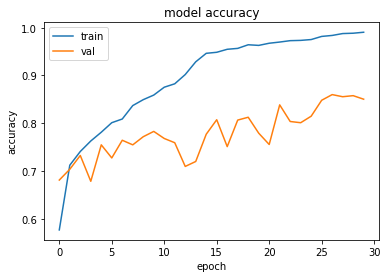

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

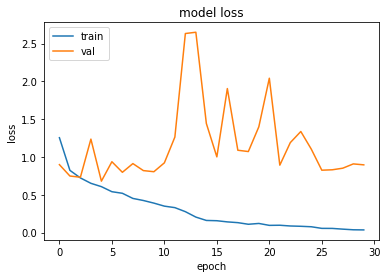

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

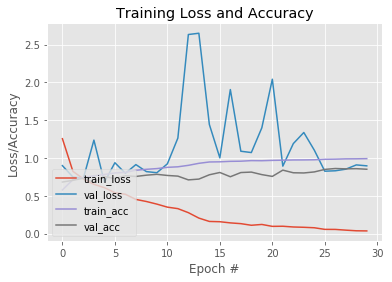

In [24]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [25]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

1703/1703 [==============================] - 50s 29ms/step


In [26]:
c=np.where(y_pred == name_as_indexes_test)

In [27]:
np.count_nonzero(c)

1402

In [28]:
print("Test Accuracy :",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy : 82.32530827950674


In [29]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(name_as_indexes_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.64      0.61      0.63        62
           1       0.80      0.64      0.71        77
           2       0.75      0.53      0.62       201
           3       0.70      0.29      0.41        24
           4       0.66      0.43      0.52       191
           5       0.86      0.97      0.91      1128
           6       0.83      1.00      0.91        20

    accuracy                           0.82      1703
   macro avg       0.75      0.64      0.67      1703
weighted avg       0.81      0.82      0.81      1703



In [ ]:
model.save("model12345.h5")